In [1]:
#@title Copyright 2020 Google LLC. Double-click here for license information.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Linear Regression with a Real Dataset

This Colab uses a real dataset to predict the prices of houses in California.   






## Learning Objectives:

After doing this Colab, you'll know how to do the following:

  * Read a .csv file into a [pandas](https://developers.google.com/machine-learning/glossary/#pandas) DataFrame.
  * Examine a [dataset](https://developers.google.com/machine-learning/glossary/#data_set). 
  * Experiment with different [features](https://developers.google.com/machine-learning/glossary/#feature) in building a model.
  * Tune the model's [hyperparameters](https://developers.google.com/machine-learning/glossary/#hyperparameter).

## The Dataset
  
The [dataset for this exercise](https://developers.google.com/machine-learning/crash-course/california-housing-data-description) is based on 1990 census data from California. The dataset is old but still provides a great opportunity to learn about machine learning programming.

## Use the right version of TensorFlow

The following hidden code cell ensures that the Colab will run on TensorFlow 2.X.

In [2]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


## Import relevant modules

The following hidden code cell imports the necessary code to run the code in the rest of this Colaboratory.

In [3]:
#@title Import relevant modules
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

## The dataset

Datasets are often stored on disk or at a URL in [.csv format](https://wikipedia.org/wiki/Comma-separated_values). 

A well-formed .csv file contains column names in the first row, followed by many rows of data.  A comma divides each value in each row. For example, here are the first five rows of the .csv file file holding the California Housing Dataset:

```
"longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"
-114.310000,34.190000,15.000000,5612.000000,1283.000000,1015.000000,472.000000,1.493600,66900.000000
-114.470000,34.400000,19.000000,7650.000000,1901.000000,1129.000000,463.000000,1.820000,80100.000000
-114.560000,33.690000,17.000000,720.000000,174.000000,333.000000,117.000000,1.650900,85700.000000
-114.570000,33.640000,14.000000,1501.000000,337.000000,515.000000,226.000000,3.191700,73400.000000
```



### Load the .csv file into a pandas DataFrame

This Colab, like many machine learning programs, gathers the .csv file and stores the data in memory as a pandas Dataframe.  pandas is an open source Python library.  The primary datatype in pandas is a DataFrame.  You can imagine a pandas DataFrame as a spreadsheet in which each row is identified by a number and each column by a name. pandas is itself built on another open source Python library called NumPy. If you aren't familiar with these technologies, please view these two quick tutorials:

*   [NumPy](https://colab.research.google.com/github/google/eng-edu/blob/master/ml/cc/exercises/numpy_ultraquick_tutorial.ipynb?utm_source=linearregressionreal-colab&utm_medium=colab&utm_campaign=colab-external&utm_content=numpy_tf2-colab&hl=en)
*   [Pandas DataFrames](https://colab.research.google.com/github/google/eng-edu/blob/master/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb?utm_source=linearregressionreal-colab&utm_medium=colab&utm_campaign=colab-external&utm_content=pandas_tf2-colab&hl=en)

The following code cell imports the .csv file into a pandas DataFrame and scales the values in the label (`median_house_value`):

In [9]:
# Import the dataset.
training_df = pd.read_csv("CarPrice_Assignment.csv")

# Scale the label.
training_df["price"] /= 1000.0
training_df["peakrpm"] /= 1000.0

training_df["curbweight"] /= 1000.0



# Print the first rows of the pandas DataFrame.
training_df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.5,2.7,9.0,111,5.0,21,27,13.5
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.5,2.7,9.0,111,5.0,21,27,16.5
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.7,3.5,9.0,154,5.0,19,26,16.5
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.2,3.4,10.0,102,5.5,24,30,13.9
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.2,3.4,8.0,115,5.5,18,22,17.4


Scaling `price` and `peakrpm` puts the value of each house in units of thousands. Scaling will keep loss values and learning rates in a friendlier range.  

Although scaling a label is usually *not* essential, scaling features in a multi-feature model usually *is* essential.

## Examine the dataset

A large part of most machine learning projects is getting to know your data. The pandas API provides a `describe` function that outputs the following statistics about every column in the DataFrame:

* `count`, which is the number of rows in that column. Ideally, `count` contains the same value for every column. 

* `mean` and `std`, which contain the mean and standard deviation of the values in each column. 

* `min` and `max`, which contain the lowest and highest values in each column.

* `25%`, `50%`, `75%`, which contain various [quantiles](https://developers.google.com/machine-learning/glossary/#quantile).

In [10]:
# Get statistics on the dataset.
training_df.describe()


,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.0,205.0,205.0,205.0,205.0,205.0,205.0,205.0,205.0,205.0,205.0,205.0,205.0,205.0,205.0,205.0
mean,103.0,0.8,98.8,174.0,65.9,53.7,2.6,126.9,3.3,3.3,10.1,104.1,5.1,25.2,30.8,13.3
std,59.3,1.2,6.0,12.3,2.1,2.4,0.5,41.6,0.3,0.3,4.0,39.5,0.5,6.5,6.9,8.0
min,1.0,-2.0,86.6,141.1,60.3,47.8,1.5,61.0,2.5,2.1,7.0,48.0,4.2,13.0,16.0,5.1
25%,52.0,0.0,94.5,166.3,64.1,52.0,2.1,97.0,3.1,3.1,8.6,70.0,4.8,19.0,25.0,7.8
50%,103.0,1.0,97.0,173.2,65.5,54.1,2.4,120.0,3.3,3.3,9.0,95.0,5.2,24.0,30.0,10.3
75%,154.0,2.0,102.4,183.1,66.9,55.5,2.9,141.0,3.6,3.4,9.4,116.0,5.5,30.0,34.0,16.5
max,205.0,3.0,120.9,208.1,72.3,59.8,4.1,326.0,3.9,4.2,23.0,288.0,6.6,49.0,54.0,45.4


### Task 1: Identify anomalies in the dataset

Do you see any anomalies (strange values) in the data? 

In [11]:
#@title Double-click to view a possible answer.

# The values seem sensible enough.

# When you see anomalies in a column, become more careful
# about using that column as a feature. That said,
# anomalies in potential features sometimes mirror 
# anomalies in the label, which could make the column 
# be (or seem to be) a powerful feature.
# Also, as you will see later in the course, you 
# might be able to represent (pre-process) raw data 
# in order to make columns into useful features.

## Define functions that build and train a model

The following code defines two functions:

  * `build_model(my_learning_rate)`, which builds a randomly-initialized model.
  * `train_model(model, feature, label, epochs)`, which trains the model from the examples (feature and label) you pass. 

Since you don't need to understand model building code right now, we've hidden this code cell.  You may optionally double-click the following headline to see the code that builds and trains a model.

In [12]:
#@title Define the functions that build and train a model
def build_model(my_learning_rate):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Describe the topography of the model.
  # The topography of a simple linear regression model
  # is a single node in a single layer.
  model.add(tf.keras.layers.Dense(units=1, 
                                  input_shape=(1,)))

  # Compile the model topography into code that TensorFlow can efficiently
  # execute. Configure training to minimize the model's mean squared error. 
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model        


def train_model(model, df, feature, label, epochs, batch_size):
  """Train the model by feeding it data."""

  # Feed the model the feature and the label.
  # The model will train for the specified number of epochs. 
  history = model.fit(x=df[feature],
                      y=df[label],
                      batch_size=None,
                      epochs=epochs)

  # Gather the trained model's weight and bias.
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # Isolate the error for each epoch.
  hist = pd.DataFrame(history.history)

  # To track the progression of training, we're going to take a snapshot
  # of the model's root mean squared error at each epoch. 
  rmse = hist["root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse

print("Defined the create_model and traing_model functions.")

Defined the create_model and traing_model functions.


## Define plotting functions

The following [matplotlib](https://developers.google.com/machine-learning/glossary/#matplotlib) functions create the following plots:

*  a scatter plot of the feature vs. the label, and a line showing the output of the trained model
*  a loss curve

You may optionally double-click the headline to see the matplotlib code, but note that writing matplotlib code is not an important part of learning ML programming.

In [13]:
#@title Define the plotting functions
def plot_the_model(trained_weight, trained_bias, feature, label):
  """Plot the trained model against 200 random training examples."""

  # Label the axes.
  plt.xlabel(feature)
  plt.ylabel(label)

  # Create a scatter plot from 200 random points of the dataset.
  random_examples = training_df.sample(n=200)
  plt.scatter(random_examples[feature], random_examples[label])

  # Create a red line representing the model. The red line starts
  # at coordinates (x0, y0) and ends at coordinates (x1, y1).
  x0 = 0
  y0 = trained_bias
  x1 = 10000
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c='r')

  # Render the scatter plot and the red line.
  plt.show()


def plot_the_loss_curve(epochs, rmse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()  

print("Defined the plot_the_model and plot_the_loss_curve functions.")

Defined the plot_the_model and plot_the_loss_curve functions.


## Call the model functions

An important part of machine learning is determining which [features](https://developers.google.com/machine-learning/glossary/#feature) correlate with the [label](https://developers.google.com/machine-learning/glossary/#label). For example, real-life home-value prediction models typically rely on hundreds of features and synthetic features. However, this model relies on only one feature. For now, you'll arbitrarily use `total_rooms` as that feature. 


Epoch 1/50
7/7 [==============================] - 0s 1ms/step - loss: 39.4401 - root_mean_squared_error: 6.2801
Epoch 2/50
7/7 [==============================] - 0s 2ms/step - loss: 23.9254 - root_mean_squared_error: 4.8914
Epoch 3/50
7/7 [==============================] - 0s 2ms/step - loss: 24.4788 - root_mean_squared_error: 4.9476
Epoch 4/50
7/7 [==============================] - 0s 2ms/step - loss: 24.7320 - root_mean_squared_error: 4.9731
Epoch 5/50
7/7 [==============================] - 0s 2ms/step - loss: 24.0637 - root_mean_squared_error: 4.9055
Epoch 6/50
7/7 [==============================] - 0s 2ms/step - loss: 25.3832 - root_mean_squared_error: 5.0382
Epoch 7/50
7/7 [==============================] - 0s 1ms/step - loss: 23.9925 - root_mean_squared_error: 4.8982
Epoch 8/50
7/7 [==============================] - 0s 2ms/step - loss: 24.3792 - root_mean_squared_error: 4.9375
Epoch 9/50
7/7 [==============================] - 0s 2ms/step - loss: 24.4273 - root_mean_squared_error:

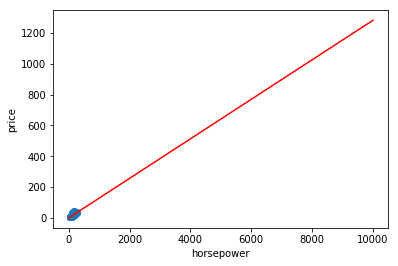

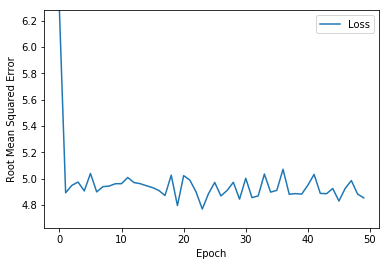

In [14]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 50
batch_size = 15

# Specify the feature and the label.
my_feature = "horsepower" 
my_label="price" 

# Discard any pre-existing version of the model.
my_model = None

# Invoke the functions.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df, 
                                         my_feature, my_label,
                                         epochs, batch_size)

print("\nThe learned weight for your model is %.4f" % weight)
print("The learned bias for your model is %.4f\n" % bias )

plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

Epoch 1/150
7/7 [==============================] - 0s 1ms/step - loss: 9403.1299 - root_mean_squared_error: 96.9697
Epoch 2/150
7/7 [==============================] - 0s 2ms/step - loss: 2503.2549 - root_mean_squared_error: 50.0325
Epoch 3/150
7/7 [==============================] - 0s 2ms/step - loss: 635.8973 - root_mean_squared_error: 25.2170
Epoch 4/150
7/7 [==============================] - 0s 1ms/step - loss: 110.7976 - root_mean_squared_error: 10.5260
Epoch 5/150
7/7 [==============================] - 0s 2ms/step - loss: 27.6836 - root_mean_squared_error: 5.2615
Epoch 6/150
7/7 [==============================] - 0s 2ms/step - loss: 22.9168 - root_mean_squared_error: 4.7871
Epoch 7/150
7/7 [==============================] - 0s 1ms/step - loss: 23.4103 - root_mean_squared_error: 4.8384
Epoch 8/150
7/7 [==============================] - 0s 2ms/step - loss: 23.1453 - root_mean_squared_error: 4.8110
Epoch 9/150
7/7 [==============================] - 0s 2ms/step - loss: 23.7821 - root_

7/7 [==============================] - 0s 2ms/step - loss: 26.8037 - root_mean_squared_error: 5.1772
Epoch 73/150
7/7 [==============================] - 0s 2ms/step - loss: 31.1565 - root_mean_squared_error: 5.5818
Epoch 74/150
7/7 [==============================] - 0s 2ms/step - loss: 36.3553 - root_mean_squared_error: 6.0295
Epoch 75/150
7/7 [==============================] - 0s 2ms/step - loss: 22.5841 - root_mean_squared_error: 4.7523
Epoch 76/150
7/7 [==============================] - 0s 2ms/step - loss: 37.1244 - root_mean_squared_error: 6.0930
Epoch 77/150
7/7 [==============================] - 0s 3ms/step - loss: 37.2483 - root_mean_squared_error: 6.1031
Epoch 78/150
7/7 [==============================] - 0s 2ms/step - loss: 22.5244 - root_mean_squared_error: 4.7460
Epoch 79/150
7/7 [==============================] - 0s 2ms/step - loss: 33.9742 - root_mean_squared_error: 5.8287
Epoch 80/150
7/7 [==============================] - 0s 2ms/step - loss: 34.9839 - root_mean_squared_e

7/7 [==============================] - 0s 1ms/step - loss: 31.8665 - root_mean_squared_error: 5.6450
Epoch 144/150
7/7 [==============================] - 0s 2ms/step - loss: 22.1457 - root_mean_squared_error: 4.7059
Epoch 145/150
7/7 [==============================] - 0s 2ms/step - loss: 29.1035 - root_mean_squared_error: 5.3948
Epoch 146/150
7/7 [==============================] - 0s 1ms/step - loss: 28.1659 - root_mean_squared_error: 5.3072
Epoch 147/150
7/7 [==============================] - 0s 2ms/step - loss: 46.2126 - root_mean_squared_error: 6.7980
Epoch 148/150
7/7 [==============================] - 0s 1ms/step - loss: 22.8059 - root_mean_squared_error: 4.7756
Epoch 149/150
7/7 [==============================] - 0s 1ms/step - loss: 31.1754 - root_mean_squared_error: 5.5835
Epoch 150/150
7/7 [==============================] - 0s 2ms/step - loss: 25.4329 - root_mean_squared_error: 5.0431

The learned weight for your model is 0.1496
The learned bias for your model is -3.3757



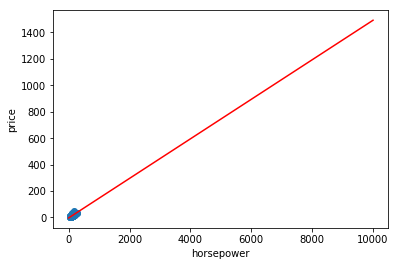

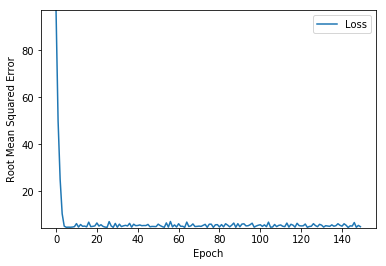

In [20]:
# The following variables are the hyperparameters.
learning_rate = 0.05
epochs = 150
batch_size = 12

# Specify the feature and the label.
my_feature = "horsepower"  
my_label="price" 

# Discard any pre-existing version of the model.
my_model = None

# Invoke the functions.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df, 
                                         my_feature, my_label,
                                         epochs, batch_size)

print("\nThe learned weight for your model is %.4f" % weight)
print("The learned bias for your model is %.4f\n" % bias )

plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

A certain amount of randomness plays into training a model. Consequently, you'll get different results each time you train the model. That said, given the dataset and the hyperparameters, the trained model will generally do a poor job describing the feature's relation to the label.

## Use the model to make predictions

You can use the trained model to make predictions. In practice, [you should make predictions on examples that are not used in training](https://developers.google.com/machine-learning/crash-course/training-and-test-sets/splitting-data). However, for this exercise, you'll just work with a subset of the same training dataset. A later Colab exercise will explore ways to make predictions on examples not used in training.

First, run the following code to define the house prediction function:

In [22]:
def predict_house_values(n, feature, label):
  """Predict house values based on a feature."""

  batch = training_df[feature][1:1 + n]
  predicted_values = my_model.predict_on_batch(x=batch)

  print("feature   label          predicted")
  print("  value   value          value")
  print("          in $(K)        in $(K)")
  print("--------------------------------------")
  for i in range(n):
    print ("%5.0f %6.0f %15.0f" % (training_df[feature][i],
                                   training_df[label][i],
                                   predicted_values[i][0] ))

##### Now, invoke the house prediction function on 15 examples:

In [23]:
predict_house_values(15, my_feature, my_label)

feature   label          predicted
  value   value          value
          in $(K)        in $(K)
--------------------------------------
  111     13              13
  111     16              20
  154     16              12
  102     14              14
  115     17              13
  110     15              13
  110     18              13
  110     19              18
  140     24              21
  160     18              12
  101     16              12
  101     17              15
  121     21              15
  121     21              15
  121     25              24


### Task 2: Judge the predictive power of the model

Look at the preceding table. How close is the predicted value to the label value?  In other words, does your model accurately predict house values?  

In [24]:
#@title Double-click to view the answer.

# Most of the predicted values differ significantly
# from the label value, so the trained model probably 
# doesn't have much predictive power. However, the
# first 10 examples might not be representative of 
# the rest of the examples.  

## Task 3: Try a different feature

The `horsepower` feature had only a little predictive power. Would a different feature have greater predictive power?  Try using `citympg` as the feature instead of `total_rooms`. 

Note: When you change features, you might also need to change the hyperparameters.

Epoch 1/150
7/7 [==============================] - 0s 1ms/step - loss: 39.8603 - root_mean_squared_error: 6.3135
Epoch 2/150
7/7 [==============================] - 0s 2ms/step - loss: 40.4350 - root_mean_squared_error: 6.3588
Epoch 3/150
7/7 [==============================] - 0s 2ms/step - loss: 38.4901 - root_mean_squared_error: 6.2040
Epoch 4/150
7/7 [==============================] - 0s 2ms/step - loss: 39.7297 - root_mean_squared_error: 6.3032
Epoch 5/150
7/7 [==============================] - 0s 2ms/step - loss: 39.1872 - root_mean_squared_error: 6.2600
Epoch 6/150
7/7 [==============================] - 0s 2ms/step - loss: 38.2933 - root_mean_squared_error: 6.1882
Epoch 7/150
7/7 [==============================] - 0s 2ms/step - loss: 38.3650 - root_mean_squared_error: 6.1939
Epoch 8/150
7/7 [==============================] - 0s 2ms/step - loss: 39.4498 - root_mean_squared_error: 6.2809
Epoch 9/150
7/7 [==============================] - 0s 2ms/step - loss: 38.6431 - root_mean_squar

7/7 [==============================] - 0s 2ms/step - loss: 34.7784 - root_mean_squared_error: 5.8973
Epoch 73/150
7/7 [==============================] - 0s 2ms/step - loss: 36.5600 - root_mean_squared_error: 6.0465
Epoch 74/150
7/7 [==============================] - 0s 2ms/step - loss: 34.8035 - root_mean_squared_error: 5.8994
Epoch 75/150
7/7 [==============================] - 0s 2ms/step - loss: 35.0955 - root_mean_squared_error: 5.9241
Epoch 76/150
7/7 [==============================] - 0s 2ms/step - loss: 34.5860 - root_mean_squared_error: 5.8810
Epoch 77/150
7/7 [==============================] - 0s 2ms/step - loss: 35.4224 - root_mean_squared_error: 5.9517
Epoch 78/150
7/7 [==============================] - 0s 2ms/step - loss: 34.5542 - root_mean_squared_error: 5.8783
Epoch 79/150
7/7 [==============================] - 0s 1ms/step - loss: 35.8440 - root_mean_squared_error: 5.9870
Epoch 80/150
7/7 [==============================] - 0s 2ms/step - loss: 35.1140 - root_mean_squared_e

7/7 [==============================] - 0s 2ms/step - loss: 34.9494 - root_mean_squared_error: 5.9118
Epoch 144/150
7/7 [==============================] - 0s 2ms/step - loss: 34.9481 - root_mean_squared_error: 5.9117
Epoch 145/150
7/7 [==============================] - 0s 1ms/step - loss: 35.2501 - root_mean_squared_error: 5.9372
Epoch 146/150
7/7 [==============================] - 0s 2ms/step - loss: 34.8445 - root_mean_squared_error: 5.9029
Epoch 147/150
7/7 [==============================] - 0s 2ms/step - loss: 34.3785 - root_mean_squared_error: 5.8633
Epoch 148/150
7/7 [==============================] - 0s 2ms/step - loss: 35.2942 - root_mean_squared_error: 5.9409
Epoch 149/150
7/7 [==============================] - 0s 2ms/step - loss: 33.6458 - root_mean_squared_error: 5.8005
Epoch 150/150
7/7 [==============================] - 0s 2ms/step - loss: 36.2678 - root_mean_squared_error: 6.0223


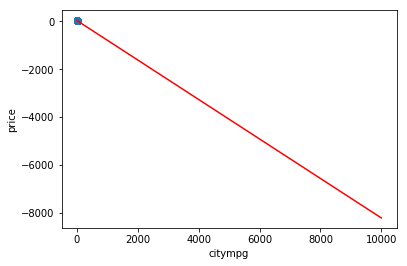

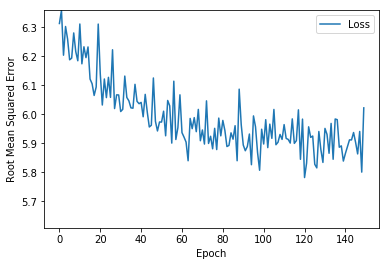

feature   label          predicted
  value   value          value
          in $(K)        in $(K)
--------------------------------------
   21     13              16
   21     16              18
   19     16              14
   24     14              19
   18     17              18
   19     15              18
   19     18              18
   19     19              19
   17     24              20
   16     18              14
   23     16              14
   23     17              16
   21     21              16
   21     21              17
   20     25              20


In [26]:
my_feature = "citympg"   # Replace the ? with population or possibly
                   # a different column name.

# Experiment with the hyperparameters.
learning_rate = 0.5
epochs = 150
batch_size = 120

# Don't change anything below this line.
model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df, 
                                         my_feature, my_label,
                                         epochs, batch_size)
plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

predict_house_values(15, my_feature, my_label)

Epoch 1/18
7/7 [==============================] - 0s 1ms/step - loss: 2904.9360 - root_mean_squared_error: 53.8975
Epoch 2/18
7/7 [==============================] - 0s 2ms/step - loss: 137.8519 - root_mean_squared_error: 11.7410
Epoch 3/18
7/7 [==============================] - 0s 2ms/step - loss: 22.3759 - root_mean_squared_error: 4.7303
Epoch 4/18
7/7 [==============================] - 0s 2ms/step - loss: 20.5549 - root_mean_squared_error: 4.5338
Epoch 5/18
7/7 [==============================] - 0s 2ms/step - loss: 20.8105 - root_mean_squared_error: 4.5619
Epoch 6/18
7/7 [==============================] - 0s 2ms/step - loss: 21.9947 - root_mean_squared_error: 4.6898
Epoch 7/18
7/7 [==============================] - 0s 2ms/step - loss: 20.6237 - root_mean_squared_error: 4.5413
Epoch 8/18
7/7 [==============================] - 0s 2ms/step - loss: 36.7583 - root_mean_squared_error: 6.0629
Epoch 9/18
7/7 [==============================] - 0s 2ms/step - loss: 27.9612 - root_mean_squared_e

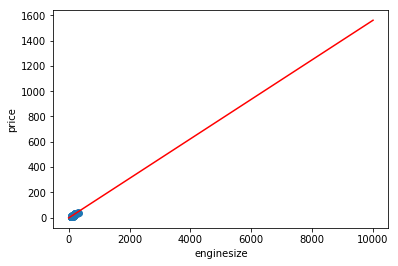

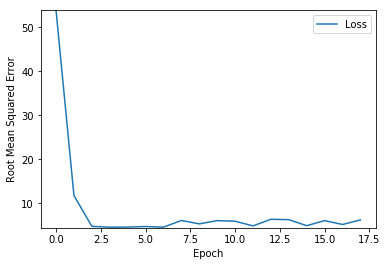

feature   label          predicted
  value   value          value
          in $(K)        in $(K)
--------------------------------------
  130     13              19
  130     16              22
  152     16              16
  109     14              20
  136     17              20
  136     15              20
  136     18              20
  136     19              19
  131     24              19
  131     18              15


In [27]:
#@title Double-click to view a possible solution.

my_feature = "enginesize" # Pick a feature other than "total_rooms"

# Possibly, experiment with the hyperparameters.
learning_rate = 0.05
epochs = 18
batch_size = 1

# Don't change anything below.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df, 
                                         my_feature, my_label,
                                         epochs, batch_size)

plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

predict_house_values(10, my_feature, my_label)

Did this variable produce better predictions than label?

In [28]:
#@title Double-click to view the answer.

# Training is not entirely deterministic, but population 
# typically converges at a slightly higher RMSE than 
# total_rooms.  So, enginesize appears to be about 
# the same or slightly worse at making predictions 
# than citympg.

## Task 4: Define a synthetic feature

You have determined that `total_rooms` and `population` were not useful features.  That is, neither the total number of rooms in a neighborhood nor the neighborhood's population successfully predicted the median house price of that neighborhood. Perhaps though, the *ratio* of `total_rooms` to `population` might have some predictive power. That is, perhaps block density relates to median house value.

To explore this hypothesis, do the following: 

1. Create a [synthetic feature](https://developers.google.com/machine-learning/glossary/#synthetic_feature) that's a ratio of `total_rooms` to `population`. (If you are new to pandas DataFrames, please study the [Pandas DataFrame Ultraquick Tutorial](https://colab.research.google.com/github/google/eng-edu/blob/master/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb?utm_source=linearregressionreal-colab&utm_medium=colab&utm_campaign=colab-external&utm_content=pandas_tf2-colab&hl=en).)
2. Tune the three hyperparameters.
3. Determine whether this synthetic feature produces 
   a lower loss value than any of the single features you 
   tried earlier in this exercise.

Epoch 1/30
7/7 [==============================] - 0s 1ms/step - loss: 199025344.0000 - root_mean_squared_error: 14107.6338
Epoch 2/30
7/7 [==============================] - 0s 2ms/step - loss: 164376752.0000 - root_mean_squared_error: 12820.9502
Epoch 3/30
7/7 [==============================] - 0s 2ms/step - loss: 141875264.0000 - root_mean_squared_error: 11911.1406
Epoch 4/30
7/7 [==============================] - 0s 2ms/step - loss: 124497792.0000 - root_mean_squared_error: 11157.8574
Epoch 5/30
7/7 [==============================] - 0s 2ms/step - loss: 109956304.0000 - root_mean_squared_error: 10486.0049
Epoch 6/30
7/7 [==============================] - 0s 2ms/step - loss: 98432408.0000 - root_mean_squared_error: 9921.3105
Epoch 7/30
7/7 [==============================] - 0s 2ms/step - loss: 88727712.0000 - root_mean_squared_error: 9419.5391
Epoch 8/30
7/7 [==============================] - 0s 2ms/step - loss: 79894616.0000 - root_mean_squared_error: 8938.3789
Epoch 9/30
7/7 [======

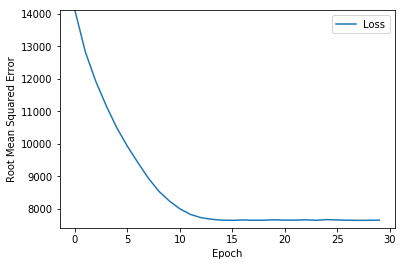

feature   label          predicted
  value   value          value
          in $           in $
--------------------------------------
 2730  13495           11878
 2730  16500           12565
 2888  16500           11382
 2616  13950           10652
 2448  17450           11243
 2584  15250           11243
 2584  17710           11243
 2584  18920            9690
 2227  23875            9121
 2096  17859           10808
 2484  16430           10808
 2484  16925           14984
 3444  20970           14984
 3444  21105           14270
 3280  24565           14549


In [71]:
# Define a synthetic feature named rooms_per_person
training_df["para"] = training_df["enginesize"]*training_df["citympg"] # write your code here.

# Don't change the next two lines.
my_feature = "para"
my_label="price" 

# Assign values to these three hyperparameters.
learning_rate = 0.05
epochs = 30
batch_size =  15

# Don't change anything below this line.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df,
                                         my_feature, my_label,
                                         epochs, batch_size)

plot_the_loss_curve(epochs, rmse)
predict_house_values(15, my_feature, my_label)

Epoch 1/100
7/7 [==============================] - 0s 1ms/step - loss: 173320208.0000 - root_mean_squared_error: 13165.1133
Epoch 2/100
7/7 [==============================] - 0s 1ms/step - loss: 142984992.0000 - root_mean_squared_error: 11957.6328
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 123573872.0000 - root_mean_squared_error: 11116.3789
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 108990936.0000 - root_mean_squared_error: 10439.8721
Epoch 5/100
7/7 [==============================] - 0s 1ms/step - loss: 96653216.0000 - root_mean_squared_error: 9831.2363
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 85954464.0000 - root_mean_squared_error: 9271.1631
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 78281336.0000 - root_mean_squared_error: 8847.6738
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 71676160.0000 - root_mean_squared_error: 8466.1777
Epoch 9/100
7/7 

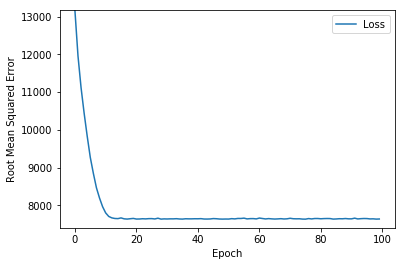

feature   label          predicted
  value   value          value
          in $           in $
--------------------------------------
 2730  13495           11966
 2730  16500           12658
 2888  16500           11466
 2616  13950           10730
 2448  17450           11326
 2584  15250           11326
 2584  17710           11326
 2584  18920            9762
 2227  23875            9188
 2096  17859           10888
 2484  16430           10888
 2484  16925           15094
 3444  20970           15094
 3444  21105           14376
 3280  24565           14656


In [75]:
#@title Double-click to view a possible solution to Task 4.

# Define a synthetic feature
training_df["para"] = training_df["enginesize"] * training_df["citympg"]
my_feature = "para"
my_label="price" 

# Tune the hyperparameters.
learning_rate = 0.05
epochs = 100
batch_size = 30

# Don't change anything below this line.
my_model = build_model(learning_rate)
weight, bias, epochs, mae = train_model(my_model, training_df,
                                        my_feature, my_label,
                                        epochs, batch_size)

plot_the_loss_curve(epochs, mae)
predict_house_values(15, my_feature, my_label)


Based on the loss values, this synthetic feature produces a better model than the individual features you tried in Task 2 and Task 3. However, the model still isn't creating great predictions.


## Task 5. Find feature(s) whose raw values correlate with the label

So far, we've relied on trial-and-error to identify possible features for the model.  Let's rely on statistics instead.

A **correlation matrix** indicates how each attribute's raw values relate to the other attributes' raw values. Correlation values have the following meanings:

  * `1.0`: perfect positive correlation; that is, when one attribute rises, the other attribute rises.
  * `-1.0`: perfect negative correlation; that is, when one attribute rises, the other attribute falls. 
  * `0.0`: no correlation; the two column's [are not linearly related](https://en.wikipedia.org/wiki/Correlation_and_dependence#/media/File:Correlation_examples2.svg).

In general, the higher the absolute value of a correlation value, the greater its predictive power. For example, a correlation value of -0.8 implies far more predictive power than a correlation of -0.2.

The following code cell generates the correlation matrix for attributes of the California Housing Dataset:

In [29]:
# Generate a correlation matrix.
training_df.corr()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
car_ID,1.0,-0.2,0.1,0.2,0.1,0.3,0.1,-0.0,0.3,-0.2,0.2,-0.0,-0.2,0.0,0.0,-0.1
symboling,-0.2,1.0,-0.5,-0.4,-0.2,-0.5,-0.2,-0.1,-0.1,-0.0,-0.2,0.1,0.3,-0.0,0.0,-0.1
wheelbase,0.1,-0.5,1.0,0.9,0.8,0.6,0.8,0.6,0.5,0.2,0.2,0.4,-0.4,-0.5,-0.5,0.6
carlength,0.2,-0.4,0.9,1.0,0.8,0.5,0.9,0.7,0.6,0.1,0.2,0.6,-0.3,-0.7,-0.7,0.7
carwidth,0.1,-0.2,0.8,0.8,1.0,0.3,0.9,0.7,0.6,0.2,0.2,0.6,-0.2,-0.6,-0.7,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
horsepower,-0.0,0.1,0.4,0.6,0.6,-0.1,0.8,0.8,0.6,0.1,-0.2,1.0,0.1,-0.8,-0.8,0.8
peakrpm,-0.2,0.3,-0.4,-0.3,-0.2,-0.3,-0.3,-0.2,-0.3,-0.1,-0.4,0.1,1.0,-0.1,-0.1,-0.1
citympg,0.0,-0.0,-0.5,-0.7,-0.6,-0.0,-0.8,-0.7,-0.6,-0.0,0.3,-0.8,-0.1,1.0,1.0,-0.7
highwaympg,0.0,0.0,-0.5,-0.7,-0.7,-0.1,-0.8,-0.7,-0.6,-0.0,0.3,-0.8,-0.1,1.0,1.0,-0.7


The correlation matrix shows nine potential features (including a synthetic
feature) and one label (`price`).  A strong negative correlation or strong positive correlation with the label suggests a potentially good feature.  

**Your Task:** Determine which of these potential features appears to be the best candidate for a feature?

In [30]:
#@title Double-click here for the solution to Task 5

# The `enginesize` correlates 0.9 with the label 
# (price), so `enginesize` might be a 
# good feature. The other seven potential features
# all have a correlation relatively close to 0. 

# If time permits, try enginesize as the feature
# and see whether the model improves.

Correlation matrices don't tell the entire story. In later exercises, you'll find additional ways to unlock predictive power from potential features.

Epoch 1/500
7/7 [==============================] - 0s 2ms/step - loss: 230.4618 - root_mean_squared_error: 15.1810
Epoch 2/500
7/7 [==============================] - 0s 3ms/step - loss: 192.7575 - root_mean_squared_error: 13.8837
Epoch 3/500
7/7 [==============================] - 0s 3ms/step - loss: 167.8087 - root_mean_squared_error: 12.9541
Epoch 4/500
7/7 [==============================] - 0s 3ms/step - loss: 146.4783 - root_mean_squared_error: 12.1028
Epoch 5/500
7/7 [==============================] - 0s 2ms/step - loss: 128.3718 - root_mean_squared_error: 11.3301
Epoch 6/500
7/7 [==============================] - 0s 2ms/step - loss: 112.0552 - root_mean_squared_error: 10.5856
Epoch 7/500
7/7 [==============================] - 0s 3ms/step - loss: 98.6267 - root_mean_squared_error: 9.9311
Epoch 8/500
7/7 [==============================] - 0s 2ms/step - loss: 86.2412 - root_mean_squared_error: 9.2866
Epoch 9/500
7/7 [==============================] - 0s 3ms/step - loss: 75.9742 - roo

7/7 [==============================] - 0s 2ms/step - loss: 30.8061 - root_mean_squared_error: 5.5503
Epoch 73/500
7/7 [==============================] - 0s 2ms/step - loss: 30.5770 - root_mean_squared_error: 5.5296
Epoch 74/500
7/7 [==============================] - 0s 2ms/step - loss: 30.5889 - root_mean_squared_error: 5.5307
Epoch 75/500
7/7 [==============================] - 0s 1ms/step - loss: 30.3284 - root_mean_squared_error: 5.5071
Epoch 76/500
7/7 [==============================] - 0s 2ms/step - loss: 30.2055 - root_mean_squared_error: 5.4960
Epoch 77/500
7/7 [==============================] - 0s 2ms/step - loss: 30.1605 - root_mean_squared_error: 5.4919
Epoch 78/500
7/7 [==============================] - 0s 1ms/step - loss: 29.8956 - root_mean_squared_error: 5.4677
Epoch 79/500
7/7 [==============================] - 0s 2ms/step - loss: 29.8634 - root_mean_squared_error: 5.4647
Epoch 80/500
7/7 [==============================] - 0s 2ms/step - loss: 29.6008 - root_mean_squared_e

7/7 [==============================] - 0s 2ms/step - loss: 23.5476 - root_mean_squared_error: 4.8526
Epoch 144/500
7/7 [==============================] - 0s 2ms/step - loss: 23.4338 - root_mean_squared_error: 4.8408
Epoch 145/500
7/7 [==============================] - 0s 1ms/step - loss: 23.3276 - root_mean_squared_error: 4.8299
Epoch 146/500
7/7 [==============================] - 0s 2ms/step - loss: 23.3010 - root_mean_squared_error: 4.8271
Epoch 147/500
7/7 [==============================] - 0s 2ms/step - loss: 23.2556 - root_mean_squared_error: 4.8224
Epoch 148/500
7/7 [==============================] - 0s 1ms/step - loss: 23.1785 - root_mean_squared_error: 4.8144
Epoch 149/500
7/7 [==============================] - 0s 2ms/step - loss: 23.1437 - root_mean_squared_error: 4.8108
Epoch 150/500
7/7 [==============================] - 0s 2ms/step - loss: 23.0500 - root_mean_squared_error: 4.8010
Epoch 151/500
7/7 [==============================] - 0s 2ms/step - loss: 23.0129 - root_mean_s

7/7 [==============================] - 0s 2ms/step - loss: 20.6296 - root_mean_squared_error: 4.5420
Epoch 215/500
7/7 [==============================] - 0s 2ms/step - loss: 20.6193 - root_mean_squared_error: 4.5409
Epoch 216/500
7/7 [==============================] - 0s 2ms/step - loss: 20.6451 - root_mean_squared_error: 4.5437
Epoch 217/500
7/7 [==============================] - 0s 2ms/step - loss: 20.5732 - root_mean_squared_error: 4.5358
Epoch 218/500
7/7 [==============================] - 0s 3ms/step - loss: 20.5675 - root_mean_squared_error: 4.5351
Epoch 219/500
7/7 [==============================] - 0s 3ms/step - loss: 20.5839 - root_mean_squared_error: 4.5369
Epoch 220/500
7/7 [==============================] - 0s 2ms/step - loss: 20.5679 - root_mean_squared_error: 4.5352
Epoch 221/500
7/7 [==============================] - 0s 3ms/step - loss: 20.5560 - root_mean_squared_error: 4.5339
Epoch 222/500
7/7 [==============================] - 0s 3ms/step - loss: 20.4323 - root_mean_s

7/7 [==============================] - 0s 1ms/step - loss: 19.6397 - root_mean_squared_error: 4.4317
Epoch 286/500
7/7 [==============================] - 0s 2ms/step - loss: 19.7199 - root_mean_squared_error: 4.4407
Epoch 287/500
7/7 [==============================] - 0s 2ms/step - loss: 19.7824 - root_mean_squared_error: 4.4477
Epoch 288/500
7/7 [==============================] - 0s 2ms/step - loss: 19.7788 - root_mean_squared_error: 4.4473
Epoch 289/500
7/7 [==============================] - 0s 2ms/step - loss: 19.6410 - root_mean_squared_error: 4.4318
Epoch 290/500
7/7 [==============================] - 0s 2ms/step - loss: 19.8223 - root_mean_squared_error: 4.4522
Epoch 291/500
7/7 [==============================] - 0s 2ms/step - loss: 19.6044 - root_mean_squared_error: 4.4277
Epoch 292/500
7/7 [==============================] - 0s 3ms/step - loss: 19.6117 - root_mean_squared_error: 4.4285
Epoch 293/500
7/7 [==============================] - 0s 2ms/step - loss: 19.6542 - root_mean_s

7/7 [==============================] - 0s 2ms/step - loss: 19.3606 - root_mean_squared_error: 4.4001
Epoch 356/500
7/7 [==============================] - 0s 2ms/step - loss: 19.4264 - root_mean_squared_error: 4.4075
Epoch 357/500
7/7 [==============================] - 0s 2ms/step - loss: 19.3446 - root_mean_squared_error: 4.3982
Epoch 358/500
7/7 [==============================] - 0s 2ms/step - loss: 19.4741 - root_mean_squared_error: 4.4130
Epoch 359/500
7/7 [==============================] - 0s 2ms/step - loss: 19.3597 - root_mean_squared_error: 4.4000
Epoch 360/500
7/7 [==============================] - 0s 2ms/step - loss: 19.4738 - root_mean_squared_error: 4.4129
Epoch 361/500
7/7 [==============================] - 0s 2ms/step - loss: 19.3864 - root_mean_squared_error: 4.4030
Epoch 362/500
7/7 [==============================] - 0s 2ms/step - loss: 19.3882 - root_mean_squared_error: 4.4032
Epoch 363/500
7/7 [==============================] - 0s 2ms/step - loss: 19.3955 - root_mean_s

7/7 [==============================] - 0s 3ms/step - loss: 19.2930 - root_mean_squared_error: 4.3924
Epoch 427/500
7/7 [==============================] - 0s 2ms/step - loss: 19.3092 - root_mean_squared_error: 4.3942
Epoch 428/500
7/7 [==============================] - 0s 2ms/step - loss: 19.3294 - root_mean_squared_error: 4.3965
Epoch 429/500
7/7 [==============================] - 0s 2ms/step - loss: 19.3244 - root_mean_squared_error: 4.3960
Epoch 430/500
7/7 [==============================] - 0s 2ms/step - loss: 19.3297 - root_mean_squared_error: 4.3966
Epoch 431/500
7/7 [==============================] - 0s 2ms/step - loss: 19.2621 - root_mean_squared_error: 4.3889
Epoch 432/500
7/7 [==============================] - 0s 2ms/step - loss: 19.3813 - root_mean_squared_error: 4.4024
Epoch 433/500
7/7 [==============================] - 0s 2ms/step - loss: 19.3189 - root_mean_squared_error: 4.3953
Epoch 434/500
7/7 [==============================] - 0s 1ms/step - loss: 19.3174 - root_mean_s

7/7 [==============================] - 0s 2ms/step - loss: 19.2556 - root_mean_squared_error: 4.3881
Epoch 498/500
7/7 [==============================] - 0s 1ms/step - loss: 19.2532 - root_mean_squared_error: 4.3878
Epoch 499/500
7/7 [==============================] - 0s 2ms/step - loss: 19.3074 - root_mean_squared_error: 4.3940
Epoch 500/500
7/7 [==============================] - 0s 1ms/step - loss: 19.3307 - root_mean_squared_error: 4.3967


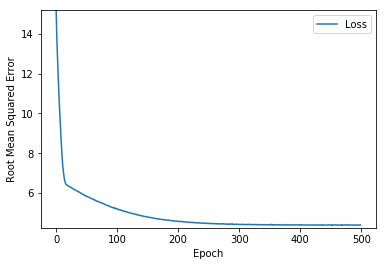

feature   label          predicted
  value   value          value
          in $(K)        in $(K)
--------------------------------------
    3     13              13
    3     16              17
    3     16              10
    2     14              17
    3     17              13
    3     15              17
    3     18              18
    3     19              20
    3     24              19
    3     18              11
    2     16              11
    2     17              15
    3     21              16
    3     21              19
    3     25              22
    3     31              24
    3     41              25
    4     37              -0
    1      5               5
    2      6               5
    2      7               5
    2      6               5
    2      6               8
    2      8               6
    2      6               6


In [31]:
#@title Double-click to view a possible solution to Task 4.

# Using median_income
#tried `enginesize`  and `horsepower` initially as corr are 0.9 and 0.8 resp
#my_feature = "enginesize"


my_feature = "curbweight" 
my_label="price" 

# Tune the hyperparameters.
learning_rate = 0.04
epochs = 500
batch_size = 25

# Don't change anything below this line.
my_model = build_model(learning_rate)
weight, bias, epochs, mae = train_model(my_model, training_df,
                                        my_feature, my_label,
                                        epochs, batch_size)

plot_the_loss_curve(epochs, mae)
predict_house_values(25, my_feature, my_label)